In [1]:
#install required packages
!pip install atlasopenmagic
!pip install pyarrow==20.0.0 awkward==2.8.5
!pip install polars

# from atlasopenmagic import install_from_environment
# install_from_environment(environment_file="environment.yml")

In [2]:
import sys
import os
import re
import awkward as ak 
import vector
import time
import datetime
from zoneinfo import ZoneInfo
import uproot
import glob
import polars as pl
import numpy as np # for numerical calculations such as histogramming
import hist
from hist import Hist
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator, AutoMinorLocator # for minor ticks
from collections import defaultdict

sys.path.append('./backend')
from ValidateVariables import validate_variables
from GetInputMagic import get_samples_magic # Build a dict that consists of the root files' name
from RunAnalysisUproot import analysis, get_data, calc_sum_of_weights
from PqRunAnalysis import analysis_parquet
from ReadParquetAk import read_parquet_ak
from ReadParquetPolars import read_parquet_polars
from PqMultipleRuns import get_combined_data, plot_combined_data
from HistPlotting import plot_histogram_hist, histogram_2d
from PklReaderWriter import pkl_reader, pkl_writer

Active release set to: 2025e-13tev-beta. Metadata cache cleared.


The string code for the available final-state collections:

* '2to4lep' - two to four leptons with at least 7 GeV of $p_T$ each
* '2muons' - at least two muons with at least 10 GeV of $p_T$
* 'GamGam' - at least two photons with at least 25 GeV of $p_T$ each
* 'exactly4lep' - exactly four leptons with at least 7 GeV of $p_T$

The string code for the available Monte Carlo simulation dataset:
* 'Zee'
* 'Zmumu'
* 'Ztautau'
* 'Wlepnu'
* 'ttbar'
* 'H'
* 'ZZllll'

Please use '+' to combine data sets. For example, if you want to combine the data for the physics processes of $Z\rightarrow\tau\tau$ and $ZZ^{*}\rightarrow llll$, write 'Ztautau+ZZllll'.

Please include '**Data**' in the key defined for the final-state collection and '**Signal**' for the physical processes simulated by the MC. Remember, strings in Python are case-sensitive! Please do not include 'Data' in the key if you don't want to store the real data as its value. Likewise, please avoid having 'Signal' in the key if it is not a Monte Carlo simulated data set that models the physics process that you want to study.
The functions defined to analyse and plot the data rely heavily on the presence of the keywords '**Data**' and '**Signal**'. Please see the scripts in the backend folder if you are interested in how the functions are defined. You are recommended not to modify the scripts in the backend folder.

In [3]:
dict_input = {
     'Data 2to4lep' : 'Data',
     'Signal $Z→ee$' : 'Zee',
     'Signal $Z→μμ$' : 'Zmumu'
}
skim_input = '2to4lep'

In [4]:
samples = get_samples_magic(dict_input=dict_input, skim_input=skim_input)
samples

Fetching and caching all metadata for release: 2025e-13tev-beta...
Successfully cached 374 datasets.
File ODEO_FEB2025_v0_2to4lep_data15_periodD.2to4lep.root already exists in backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data15_periodE.2to4lep.root already exists in backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data15_periodF.2to4lep.root already exists in backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data15_periodG.2to4lep.root already exists in backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data15_periodH.2to4lep.root already exists in backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data15_periodJ.2to4lep.root already exists in backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to4lep_data16_periodA.2to4lep.root already exists in backend/datasets/2to4lep/Data. Skipping download.
File ODEO_FEB2025_v0_2to

{'Data 2to4lep': ['backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data15_periodD.2to4lep.root',
  'backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data15_periodE.2to4lep.root',
  'backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data15_periodF.2to4lep.root',
  'backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data15_periodG.2to4lep.root',
  'backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data15_periodH.2to4lep.root',
  'backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data15_periodJ.2to4lep.root',
  'backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data16_periodA.2to4lep.root',
  'backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data16_periodB.2to4lep.root',
  'backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data16_periodC.2to4lep.root',
  'backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data16_periodD.2to4lep.root',
  'backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data16_periodE.2to4lep.root',
  'backend/datasets/2to4lep

In [5]:
luminosity = 36.6
fraction = 0.2
# Define what variables are important to our analysis
variables = ["lep_n", "lep_pt", "lep_eta", "lep_phi", "lep_e", 
             "lep_ptvarcone30", "lep_topoetcone20", 
             "lep_type", "lep_charge",
             #"lep_isLooseID", "lep_isMediumID", "lep_isTightID",
             #"lep_isLooseIso", "lep_isTightIso",
             #"trigE",
             "trigM", "lep_isTrigMatched"]


In [6]:
variables = validate_variables(variables)

In [7]:
# Note: first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
# Functions return bool. True means we should remove the event

# Function to cut on the number of leptons in each event
def cut_lep_n(lep_n, user_input):
    return (lep_n == user_input)

# Function to cut on the lepton type (based on type of first two lep_type)
# lep_type is a number signifying the lepton type (electron (11) or muon (13))
def cut_lep_type(lep_type, user_input):
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1] # Sum of first two leptons' type in the event 
    return (sum_lep_type == user_input)

# Function to cut on the lepton charge (based on charge of first two lep_charge)
def cut_lep_charge(lep_charge, user_input):
    product_lep_charge = lep_charge[:, 0] * lep_charge[:, 1] # Product of first two leptons' charge in the event
    return (product_lep_charge == user_input)

# Function to cut on the lepton transverse momentum
def cut_lep_pt(lep_pt, index, lower_limit):
    return (lep_pt[:, index] > lower_limit) # Accept events with lepton pt higher than lower limit

# Function to cut on the isolation pt (based on first two leptons)
def cut_lep_ptvarcone30(lep_ptvarcone30, upper_limit):
    # Accept events with lep_ptvarcone30 in the range
    return (lep_ptvarcone30[:, 0] < upper_limit) & (lep_ptvarcone30[:, 1] < upper_limit)

# Function to cut on the isolation et (based on first two leptons)
def cut_lep_topoetcone20(lep_topoetcone20, upper_limit):
    # Accept events with lep_topoetcone20 in the range
    return (lep_topoetcone20[:, 0] < upper_limit) & (lep_topoetcone20[:, 1] < upper_limit)

# Function to accept events with at least one lepton is triggering
def cut_trig_match(lep_trigmatch): 
    return ak.sum(lep_trigmatch, axis=1) >= 1

# # Function to accept events that has been selected by any of the single electron OR muon triggers
# def cut_trig(trigE, trigM):
#     return trigE | trigM

# Function to accept events that has been selected by any of the single electron OR muon triggers
def cut_trig(trigM):
    return trigM

# # Function to filter events based on the identification and isolation criteria of all leptons in each event
# def ID_iso_cut(electron_isID, muon_isID, electron_isIso, muon_isIso, lep_type, lep_n): 
#     return (ak.sum(((lep_type == 13) & muon_isID & muon_isIso) | 
#                    ((lep_type == 11) & electron_isID & electron_isIso), axis=1) == lep_n)

# Function to keep events that have all leptons passed the identification and isolation criteria
def ID_iso_cut(lep_isID, lep_isIso, lep_n): 
    return (ak.sum(lep_isID & lep_isIso, axis=1) == lep_n)

# Function to calculate the invariant mass using four momentum (pt, eta, phi, energy)    
def calculate_inv_mass(lep_pt, lep_eta, lep_phi, lep_e):
    four_momentum = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_e})
    invariant_mass = (four_momentum[:, 0] + four_momentum[:, 1]).M

    return invariant_mass

def selection_cut(data):
    # Keep events that pass electron / muon trigger 
    # data = data[cut_trig(data['trigM'])]
    # # Keep events where at least one lepton is triggering
    # data = data[cut_trig_match(data['lep_isTrigMatched'])]

    # Lepton cuts
    # lep_n = data['lep_n']
    # data = data[cut_lep_n(lep_n, 2)]

    # one electron one muon, 11 + 13 = 24
    # two muons 13 * 2 = 26
    # two electrons 11 * 2 = 22
    lep_type = data['lep_type']
    dimu_or_die = cut_lep_type(lep_type, 26) | cut_lep_type(lep_type, 22)
    data = data[dimu_or_die]
    
    lep_charge = data['lep_charge']
    data = data[cut_lep_charge(lep_charge, -1)]
    
    # Invariant Mass
    data['mass'] = calculate_inv_mass(data['lep_pt'], data['lep_eta'], data['lep_phi'], data['lep_e'])

    return data

In [12]:
filename_pq = 'txtfiles/pq-23-07-2025.txt'

now = datetime.datetime.now(ZoneInfo("Europe/London"))
date_time = now.strftime("%Y%m%d%H%M")
output_folder_pq = f'output/frac{fraction}_mass_pt_{date_time}'
save_variables_input = ["mass", "lep_pt"
                          #, "lep_n", "lep_pt", "lep_eta", "lep_phi", "lep_e", 
                         #"lep_ptvarcone30", "lep_topoetcone20", 
                         #"lep_type", "lep_charge"
                       ]
analysis_parquet(luminosity, fraction, samples, selection_cut, variables,
                 save_variables_input, filename_pq, output_directory=output_folder_pq)


Reminder: variable 'mass' will only be saved if it is computed and saved in the cut_function.
Processing Data 2to4lep samples
	backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data15_periodD.2to4lep.root:


TypeError: calc_sum_of_weights() takes 1 positional argument but 2 were given

In [8]:
filename = 'txtfiles/ori-24-07-2025.txt'
now = datetime.datetime.now(ZoneInfo("Europe/London"))
date_time = now.strftime("%Y%m%d%H%M")
output_filename = f'output_pkl/frac{fraction}_pt_{date_time}'
save_variables_input = ['lep_pt'
                          #, "lep_n", "lep_pt", "lep_eta", "lep_phi", "lep_e", 
                         #"lep_ptvarcone30", "lep_topoetcone20", 
                         #"lep_type", "lep_charge"
                       ]

all_data = analysis(luminosity, fraction, samples, cut_function=selection_cut,
                    read_variables_input=variables,
                    save_variables_input=save_variables_input,
                    # Below are optional args
                    write_txt=True, txt_filename=filename,
                    output_pkl_filename=output_filename, write_pickle=True,
                    return_output=False)
# Return output successfully? Yes
# Save to pickle successfully? Yes
# Can the pkl be read? Yes
# Can provide output_pkl_filename? Yes
# Can not return output and write only pkl? Yes
# Can not do both? Yes
# Can write txt? Yes
# Can provide txt_filename? Yes

Processing Data 2to4lep samples
	backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data15_periodD.2to4lep.root:
		 nIn: 176042,	 nOut: 	85345	 in 1.1s
	backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data15_periodE.2to4lep.root:
		 nIn: 1270125,	 nOut: 	672397	 in 4.6s
		 nIn: 35108,	 nOut: 	18187	 in 4.9s
	backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data15_periodF.2to4lep.root:
		 nIn: 836657,	 nOut: 	469504	 in 2.7s
	backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data15_periodG.2to4lep.root:
		 nIn: 1273699,	 nOut: 	732145	 in 4.3s
		 nIn: 599955,	 nOut: 	345295	 in 6.3s
	backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data15_periodH.2to4lep.root:
		 nIn: 573125,	 nOut: 	337200	 in 1.7s
	backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data15_periodJ.2to4lep.root:
		 nIn: 1273316,	 nOut: 	751745	 in 4.3s
		 nIn: 1273316,	 nOut: 	748024	 in 8.7s
		 nIn: 687780,	 nOut: 	404296	 in 10.8s
	backend/datasets/2to4lep/Data/ODEO_FEB2025_v0_2to4lep_data16_

In [15]:
all_data

In [22]:
def calc_bytes_gb(data): 
    total_bytes = 0
    for i in data:
        for var in data[i].fields:
            total_bytes += data[i][var].nbytes
    return total_bytes / 1024**3
calc_bytes_gb(all_data)

0.04997983202338219

In [18]:
zee = all_data['Signal $Z→ee$']
real_data = all_data['Data 2to4lep']
mask_zee = zee['lep_pt'][:, 0] > 20  # boolean mask
mask_data = real_data['lep_pt'][:, 0] > 20

def cut_function_input(data):
    data = data[(data['lep_pt'][:, 0] > 20) & (data['mass'] > 20)]
    return data

def cut_func(data):
    filtered = {}
    data = cut_function_input(data)
    for key, value in data.items():
        if isinstance(value, ak.Array):
            filtered[key] = value[mask]
        
    if 'totalWeight' in filtered:
        filtered['events'] = sum(filtered['totalWeight'])
    else:
        # Use length of first array-like key
        for val in filtered.values():
            if isinstance(val, ak.Array):
                filtered['events'] = len(val)
                break
        else:
            filtered['events'] = None
    return filtered
    
cut_func(zee)

TypeError: unhashable type: 'Array'

In [12]:
output_filename = 'output_pkl/frac0.005_mass_202507241752.pkl'
data = pkl_reader(output_filename)
data

{'Data 2to4lep': <Array [{mass: 96.5, lep_pt: [...]}, ...] type='921558 * {mass: float32, le...'>,
 'Signal $Z→ee$': <Array [{mass: 81.6, lep_pt: [...], ...}, ...] type='257687 * {mass: float3...'>,
 'Signal $Z→μμ$': <Array [{mass: 91.7, lep_pt: [...], ...}, ...] type='273595 * {mass: float3...'>}

In [9]:
pkl_writer(all_data)

'save_output202507241612'

In [3]:
def further_cut(data):
    # has_4leptons = ak.num(data['lep_pt'], axis=1) == 2
    # data = data[has_4leptons]
    # pt_cut = data['lep_pt'][:, 1] > 20
    # data = data[pt_cut]
    return data


# No cut on lep_n. Di-e, di-mu.
#read_pkl_filename = 'output_pkl/frac0.1_pt_202507241933.pkl'
read_pkl_filename = 'output_pkl/frac0.2_pt_202507241938.pkl'

variable_list = ['lep_pt']
selected = get_data(variable_list, data=None,
                    read_pkl_filename=read_pkl_filename,
                   cut_function=further_cut)
selected

# Can provide data? Yes
# Can provide pkl file? Yes
# Can both? Yes. will read pkl file
# Can not both? No
# Can cut? Yes
# Changing to ak.zip saves more memory?

Elapsed time = 5.5s


{'Data 2to4lep': {'lep_pt[0]': <Array [39.4, 19.9, 45.2, ..., 34.8, 21.4, 34.1] type='37045695 * ?float32'>,
  'lep_pt[1]': <Array [42.3, 9.98, 42.1, 45.5, ..., 30.5, 29, 46.2] type='37045695 * ?float32'>,
  'lep_pt[2]': <Array [None, None, None, ..., None, None, None] type='37045695 * ?float32'>,
  'lep_pt[3]': <Array [None, None, None, ..., None, None, None] type='37045695 * ?float32'>},
 'Signal $Z→ee$': {'lep_pt[0]': <Array [104, 99.8, 65.8, 249, ..., 55, 54.4, 57.8] type='10314494 * ?float32'>,
  'lep_pt[1]': <Array [42.3, 56.3, 29.6, ..., 41.9, 41.9, 33.8] type='10314494 * ?float32'>,
  'lep_pt[2]': <Array [None, None, None, ..., None, None, None] type='10314494 * ?float32'>,
  'lep_pt[3]': <Array [None, None, None, ..., None, None, None] type='10314494 * ?float32'>,
  'totalWeight': <Array [0.2, 0.31, 0.391, ..., 1.33, 0.171, 0.446] type='10314494 * float64'>},
 'Signal $Z→μμ$': {'lep_pt[0]': <Array [101, 75.4, 59.2, 183, ..., 124, 220, 47.6] type='10954014 * ?float32'>,
  'lep_

In [8]:
selected['Signal $Z→μμ$']
total_bytes = 0
for var in selected['Signal $Z→μμ$']:
    total_bytes += selected['Signal $Z→μμ$'][var].nbytes
total_bytes / 1024**3

0.7349559366703033

In [5]:
selected['Data 2to4lep']

{'lep_pt[0]': <Array [39.4, 19.9, 45.2, ..., 34.8, 21.4, 34.1] type='37045695 * ?float32'>,
 'lep_pt[1]': <Array [42.3, 9.98, 42.1, 45.5, ..., 30.5, 29, 46.2] type='37045695 * ?float32'>,
 'lep_pt[2]': <Array [None, None, None, ..., None, None, None] type='37045695 * ?float32'>,
 'lep_pt[3]': <Array [None, None, None, ..., None, None, None] type='37045695 * ?float32'>}

In [6]:
def calc_bytes_gb_dict(data): 
    total_bytes = 0
    for i in data:
        for var in data[i]:
            total_bytes += data[i][var].nbytes
    return total_bytes / 1024**3
calc_bytes_gb_dict(selected)

3.656375303864479

In [26]:
zip_selected = {key : ak.zip(value) for key, value in selected.items()}
zip_selected

{'Data 2to4lep': <Array [{mass: 96.5, ...}, {...}, ..., {...}] type='921558 * {mass: float32...'>,
 'Signal $Z→ee$': <Array [{mass: 81.6, ...}, {...}, ..., {...}] type='257687 * {mass: float32...'>,
 'Signal $Z→μμ$': <Array [{mass: 91.7, ...}, {...}, ..., {...}] type='273595 * {mass: float32...'>}

In [27]:
calc_bytes_gb(zip_selected)

0.11303892731666565

In [21]:
# import pandas as pd
# output_folder_pq = 'output/frac0.01_mass_pt_202507221858'
# df_parquet = pd.read_parquet(f'{output_folder_pq}/Data 2to4lep/chunk_1.parquet')
# df_parquet

,mass,lep_pt
0,17.871162,"[7.955563, 8.3606825]"
1,10.457856,"[9.704018, 10.95629]"
2,9.225368,"[7.238277, 9.9687395]"
3,35.633934,"[17.306793, 16.542402]"
4,0.050631,"[17.047459, 16.421354]"
...,...,...
36690,0.046219,"[8.135007, 7.3018937]"
36691,89.423386,"[44.984684, 43.158215]"
36692,19.348406,"[19.444302, 12.513818]"
36693,85.149612,"[50.515755, 35.902027]"


In [30]:
# def concatenate_chunks_new(directory, variable_list, cut_function):

#     files = sorted(glob.glob(f'{directory}/*.parquet'))

#     if not files:
#         raise FileNotFoundError(f"No .parquet files found in directory: {directory}")

#     variable_name_list = []
#     index_list = []
#     for var in variable_list:
#         match = re.match(r'([a-zA-Z_]\w*)(?:\[(\d+)\])?$', var)
#         if match:
#             variable_name = match.group(1)
#             index = int(match.group(2)) if match.group(2) else None
            
#             variable_name_list.append(variable_name)
#             index_list.append(index)
#         else:
#             raise ValueError("Invalid input variable format.")    

#     sample_dict = {}
    
#     for file in files:
        
#         array = ak.from_parquet(file, columns=variable_name_list)

#         array = cut_function(array)
        
#         for var, index in zip(variable_name_list, index_list):
#             try:
#                 data = array[var]
#             except Exception as e:
#                 print(f'Exception occured while attempting to read the variable {var} from {file} : {e}')
#                 raise

#             type_str = str(ak.type(data))
#             slicable = "var *" in type_str or re.search(r"\*\s*\d+\s*\*", type_str)

#             if index is not None:
#                 if slicable:
#                      try:
#                          new_key = f'{var}[{index}]'
#                          if new_key not in sample_dict:
#                              sample_dict[new_key] = []
#                          sample_dict[new_key].append(data[:, index])
#                      except Exception as e:
#                         print(f"Failed to access '{var}[{index}]': {e}")
#                         raise
#                 else:
#                     raise TypeError(f"Error: {var} is not slicable. Failed to access '{var}[{index}]'")
#             else: # No valid index provided in input
#                 if slicable:
#                     max_num = ak.max(ak.num(data, axis=1))
#                     for i in range(max_num):
#                         new_key = f'{var}[{i}]'
#                         if new_key not in sample_dict:
#                             sample_dict[new_key] = []
#                         sample_dict[new_key].append(data[:, i])
#                 else:
#                     if var not in sample_dict:
#                         sample_dict[var] = []
#                     sample_dict[var].append(data)
#             # End of if-else statement
#         # End of loop through variables
#     # End of loop through all parquet files
#     if len(files) > 1:
#         for i in sample_dict:
#             sample_dict[i] = ak.concatenate(sample_dict[i])
#     return sample_dict

# def get_data_new(samples, output_directory, variable_list, cut_function):
    
#     time_start = time.time()
    
#     all_data = {}
    
#     for sample_key in samples:
        
#         directory = f"{output_directory}/{sample_key}"

#         if 'Data' in sample_key and 'totalWeight' in variable_list:
#             variable_list = [var for var in variable_list if var != 'totalWeight']
#         elif 'Data' not in sample_key and 'totalWeight' not in variable_list:
#             variable_list.append('totalWeight')

#         all_data[sample_key] = concatenate_chunks_new(directory, variable_list, cut_function)
        
#     elapsed_time = time.time() - time_start 
#     print("Elapsed time = " + str(round(elapsed_time, 1)) + "s") # Print the time elapsed
                
#     return all_data

In [3]:
def cut_function(array):
    # pt_cut = array['lep_pt'][:, 0] > 20
    # array = array[pt_cut]
    return array

# output_dir = 'output/frac0.01_mass_202507181947'
# output_dir = 'output/lumi36.6_frac0.2_lep_etalep_ptmasslep_philep_typelep_n202507111704'
# output_dir = 'output/frac0.01_mass_pt_202507221858'
#output_dir = 'output/lumi36.6_frac1_masslep_nlep_ptlep_etalep_philep_elep_ptvarcone30lep_topoetcone20lep_typelep_charge202507161957'

output_dir = 'output/lumi36.6_frac0.2_lep_etalep_ptmasslep_philep_typelep_n202507111704'
samples = ['Data 2to4lep', 'Signal $Z→ee$', 'Signal $Z→μμ$']
variable_list = ['lep_pt', 'mass']
extracted = read_parquet_ak(samples, output_dir, variable_list, cut_function)
extracted

Elapsed time = 11.4s


{'Data 2to4lep': {'lep_pt[0]': <Array [39.4, 19.9, 45.2, ..., 64.9, 7.39, 14.9] type='35958711 * ?float32'>,
  'lep_pt[1]': <Array [42.3, 9.98, 42.1, ..., 34.4, 9.02, 12.9] type='35958711 * ?float32'>,
  'mass': <Array [96.5, 31.5, 88, 0.433, ..., 94.9, 9.16, 29.4] type='35958711 * float32'>},
 'Signal $Z→ee$': {'lep_pt[0]': <Array [104, 99.8, 65.8, 249, ..., 55, 54.4, 57.8] type='10089146 * ?float32'>,
  'lep_pt[1]': <Array [42.3, 56.3, 29.6, ..., 41.9, 41.9, 33.8] type='10089146 * ?float32'>,
  'mass': <Array [81.6, 92.8, 86.8, 101, ..., 89.6, 91.9, 87.7] type='10089146 * float32'>,
  'totalWeight': <Array [0.2, 0.31, 0.391, ..., 1.33, 0.171, 0.446] type='10089146 * float64'>},
 'Signal $Z→μμ$': {'lep_pt[0]': <Array [101, 75.4, 59.2, 183, ..., 124, 220, 47.6] type='10934717 * ?float32'>,
  'lep_pt[1]': <Array [57.5, 30.6, 43.3, 42.5, ..., 17, 46.1, 39.5] type='10934717 * ?float32'>,
  'mass': <Array [91.7, 88.5, 92.9, ..., 92.4, 93.6, 89.7] type='10934717 * float32'>,
  'totalWeight'

In [5]:
calc_bytes_gb(extracted)

2.067129224538803

In [4]:
# Di-e, di-mu
output_dir = 'output/lumi36.6_frac0.2_lep_etalep_ptmasslep_philep_typelep_n202507111704'
samples = ['Data 2to4lep', 'Signal $Z→ee$', 'Signal $Z→μμ$']
variable_list = ['lep_pt', 'mass']
#filter_expression = pl.col('lep_pt').list.get(1, null_on_oob=True) > 20
# Test if it works with frac = 0.2 first
polars = read_parquet_polars(samples, output_dir, variable_list)

Elapsed time = 5.2s


In [15]:
len(polars['Signal $Z→μμ$']['mass'])

10934717

In [5]:
calc_bytes_gb(polars)

0.7934698760509491

In [65]:
# Di-e, di-mu
output_dir = 'output/lumi36.6_frac0.2_lep_etalep_ptmasslep_philep_typelep_n202507111704'
samples = ['Data 2to4lep', 'Signal $Z→ee$', 'Signal $Z→μμ$']
variable_list = ['lep_pt', 'mass']
# Test if it works with frac = 0.2 first
get_data_polars(samples, output_dir, variable_list)

Elapsed time = 7.1s


{'Data 2to4lep': shape: (35_958_711, 3)
 ┌────────────┬───────────┬───────────┐
 │ lep_pt[0]  ┆ lep_pt[1] ┆ mass      │
 │ ---        ┆ ---       ┆ ---       │
 │ f32        ┆ f32       ┆ f32       │
 ╞════════════╪═══════════╪═══════════╡
 │ 39.375092  ┆ 42.321903 ┆ 96.454575 │
 │ 19.914816  ┆ 9.976838  ┆ 31.531025 │
 │ 45.167778  ┆ 42.074402 ┆ 88.017403 │
 │ 115.672882 ┆ 45.507748 ┆ 0.433013  │
 │ 44.340332  ┆ 39.255901 ┆ 92.139084 │
 │ …          ┆ …         ┆ …         │
 │ 9.179329   ┆ 7.389886  ┆ 16.964811 │
 │ 12.0088    ┆ 9.227847  ┆ 3.105093  │
 │ 64.932045  ┆ 34.393513 ┆ 94.889565 │
 │ 7.390875   ┆ 9.016066  ┆ 9.159113  │
 │ 14.917781  ┆ 12.944178 ┆ 29.44721  │
 └────────────┴───────────┴───────────┘,
 'Signal $Z→ee$': shape: (10_089_146, 4)
 ┌─────────────┬────────────┬───────────┬────────────┐
 │ totalWeight ┆ lep_pt[0]  ┆ lep_pt[1] ┆ mass       │
 │ ---         ┆ ---        ┆ ---       ┆ ---        │
 │ f64         ┆ f32        ┆ f32       ┆ f32        │
 ╞═════════════╪══

Elapsed time = 1.0s


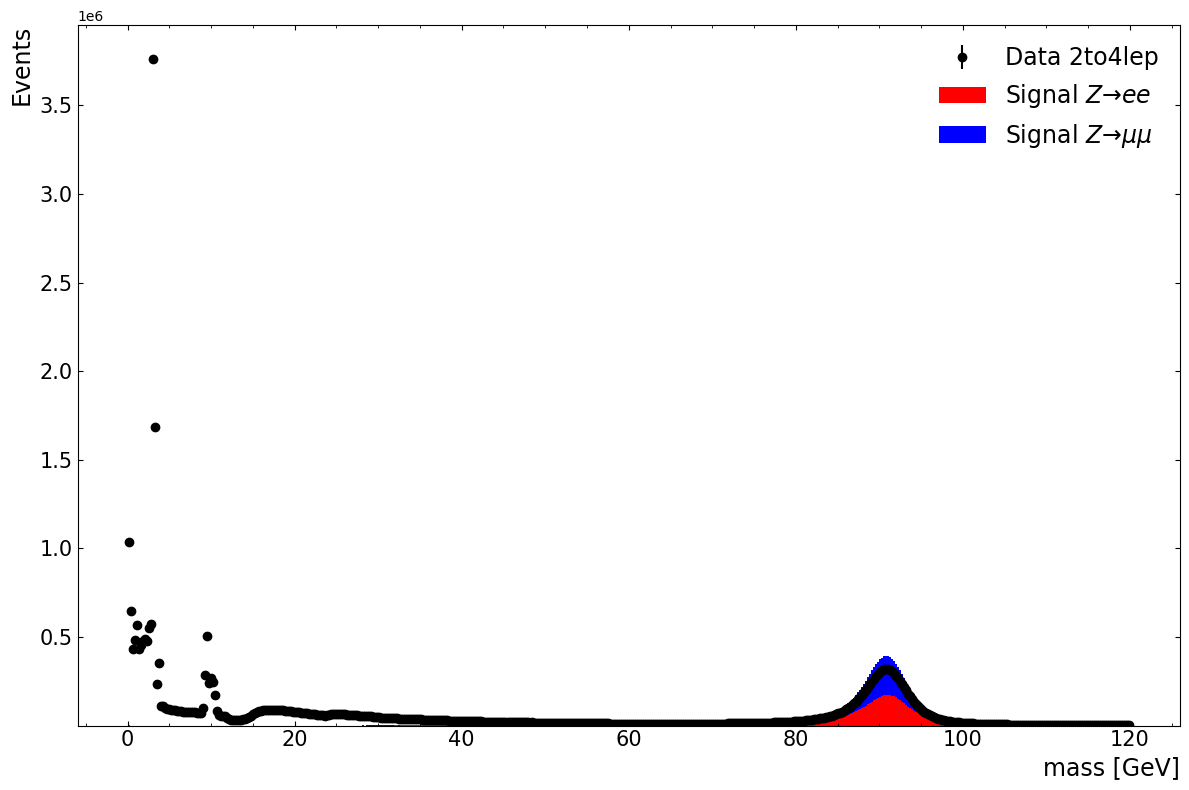

In [9]:
data = extracted
variable_list = 'mass'
color_list = ['k', 'r', 'b']
xmin_xmax_list = (0, 120)
num_bins_list = 500
x_label_list = 'mass [GeV]'

plot_histogram_hist(
    data, variable_list, color_list, xmin_xmax_list,
    num_bins_list, x_label_list,
    # Below are optional arguments
    y_label_list=[], title_list=[], # Str or list of str for y axis label and title
    marker='o', # Marker type 
    logy=False, # Whether to set the y axis as log scale
    title_fontsize=17, label_fontsize=17, # Fontsize for title and axes
    tick_labelsize=15, # Labelsize for x and y axes ticks
    fig_size=(12, 8), legend_fontsize=17, # Figure size and fontsize for legend
    text_fontsize=14, # Fontsize for text (histogram info)
    show_text=False, # Bool - whether to show text (histogram info)
    show_back_unc=True, # Bool - whether to show background uncertainty
    return_fig_hist=False # Bool - whether to return fig and hists produced
)

In [14]:
data_dict = {
    'data1' : {'color' : ['r', 'b', 'g'], 'variable' : 'mass', 'data' : extracted},
    'data2' : {'data' : extracted, 'color' : ['k', 'c', 'm'], 'variable' : 'mass'},
}
combined_data = get_combined_data(data_dict)

Elapsed time = 0.2s


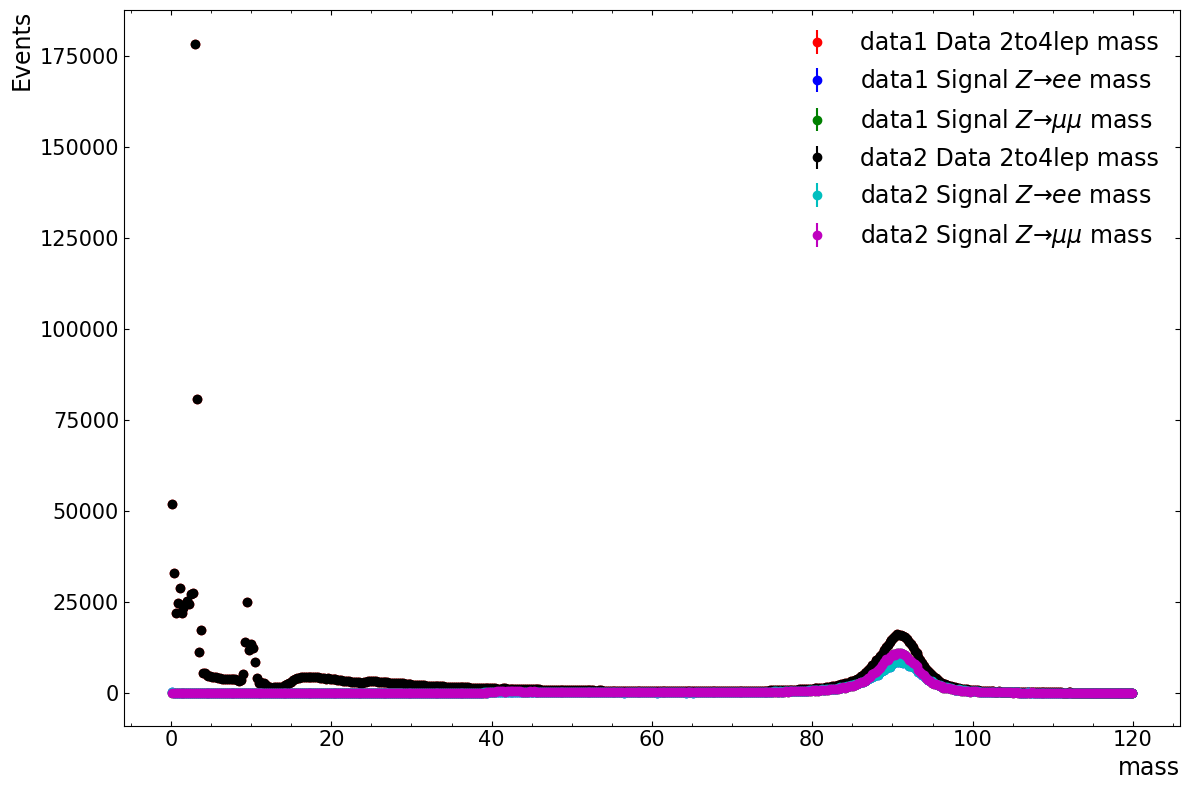

(<Figure size 1200x800 with 1 Axes>,
 [Hist(Regular(500, 0, 120, name='data1 Data 2to4lep mass'), storage=Weight()) # Sum: WeightedSum(value=1.77606e+06, variance=1.77606e+06) (WeightedSum(value=1.78981e+06, variance=1.78981e+06) with flow),
  Hist(Regular(500, 0, 120, name='data1 Signal $Z→ee$ mass'), storage=Weight()) # Sum: WeightedSum(value=350378, variance=1.31886e+06) (WeightedSum(value=354787, variance=1.33306e+06) with flow),
  Hist(Regular(500, 0, 120, name='data1 Signal $Z→μμ$ mass'), storage=Weight()) # Sum: WeightedSum(value=393430, variance=1.47962e+06) (WeightedSum(value=397864, variance=1.49325e+06) with flow),
  Hist(Regular(500, 0, 120, name='data2 Data 2to4lep mass'), storage=Weight()) # Sum: WeightedSum(value=1.77606e+06, variance=1.77606e+06) (WeightedSum(value=1.78981e+06, variance=1.78981e+06) with flow),
  Hist(Regular(500, 0, 120, name='data2 Signal $Z→ee$ mass'), storage=Weight()) # Sum: WeightedSum(value=350378, variance=1.31886e+06) (WeightedSum(value=354787,

In [16]:
data = combined_data
xmin, xmax = 0, 120
num_bins = 500
x_label = 'mass'

plot_combined_data( data,
                           xmin,
                           xmax,
                           num_bins,
                           x_label,
                           y_label='Events',
                           logy=False,
                           title='',
                           marker='o',
                           title_fontsize=17,
                           label_fontsize=17,
                           legend_fontsize=17,
                           tick_labelsize=15,
                            text_fontsize=14,
                            show_text=False,
                            fig_size=(12, 8),
                      return_fig_hist=True)

## Demonstration of plotting multiple variables

Elapsed time = 0.2s


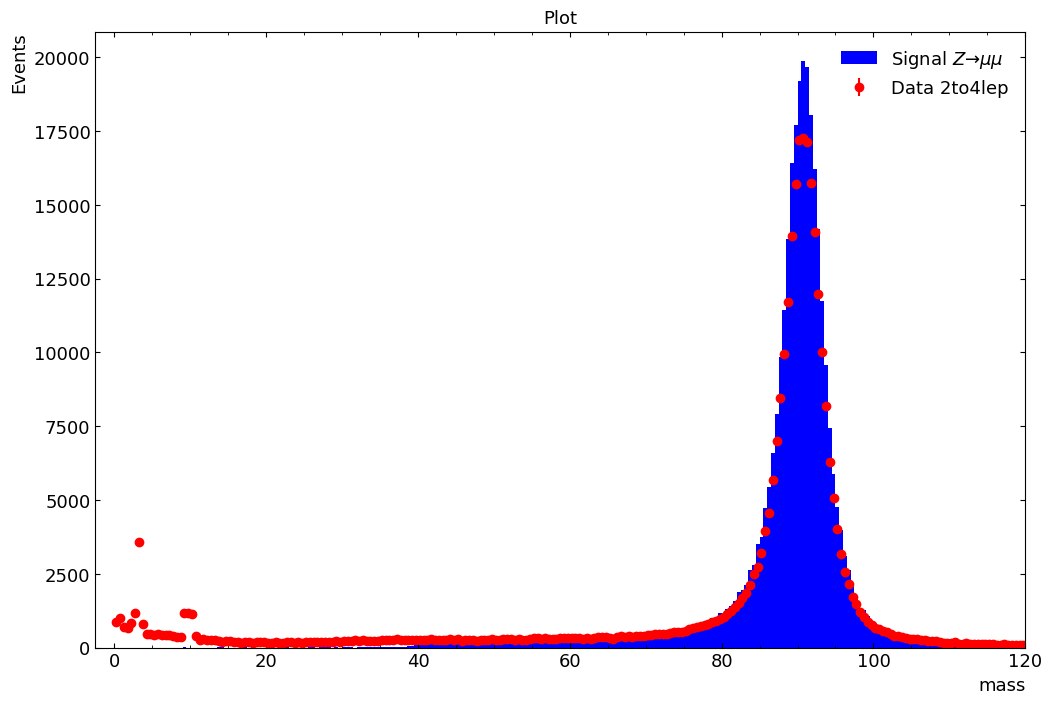

In [9]:
# Single variable is acceptable
plot_histogram_new(run1,
                   ['mass'],
                   ['r', 'b'],
                   (xmin, xmax),
                   0.5,
                   ['mass'],
                   y_label_list=['Events'],
                   title_list=['Plot'])

Elapsed time = 0.2s


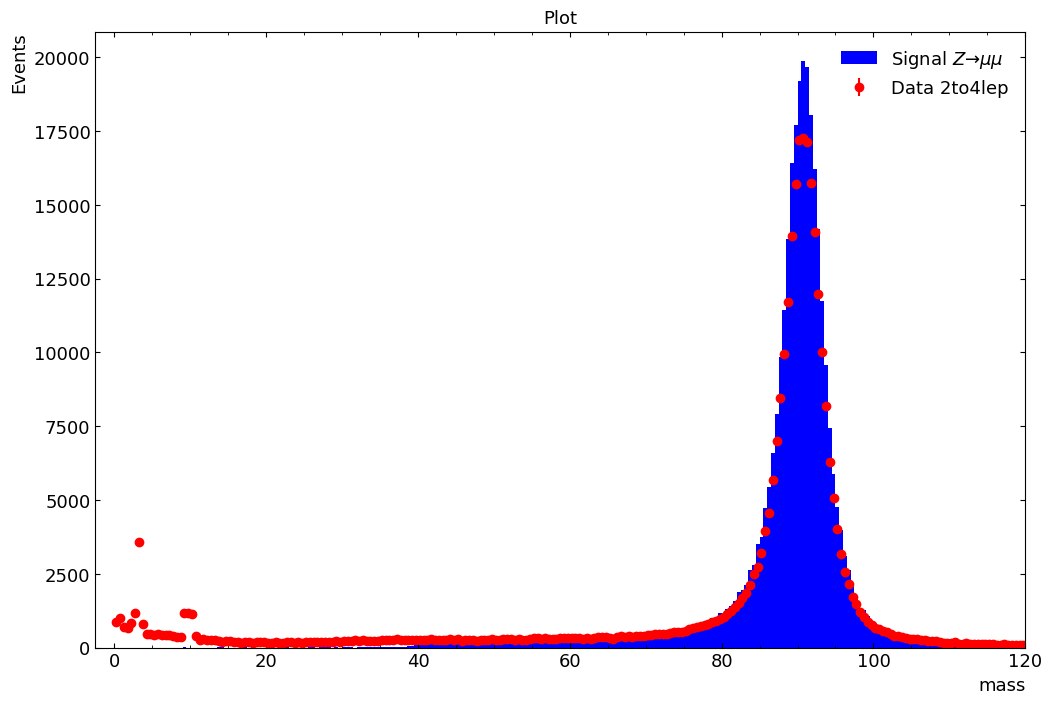

In [10]:
# Str input is acceptable
plot_histogram_new(run1,
                   'mass', # Str input is acceptable
                   ['r', 'b'],
                   (xmin, xmax),
                   0.5,
                   'mass', # Str input is acceptable
                   y_label_list='Events', # Str input is acceptable
                   title_list='Plot') # Str input is acceptable

Elapsed time = 1.0s


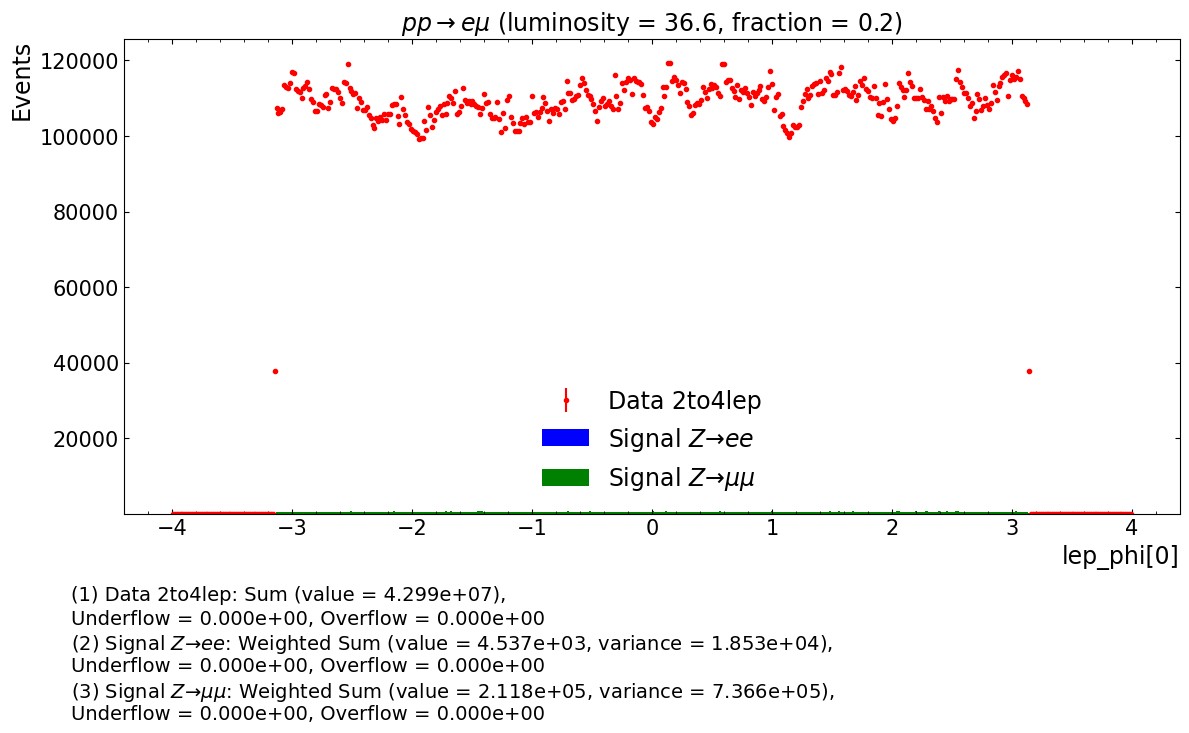

Elapsed time = 3.2s


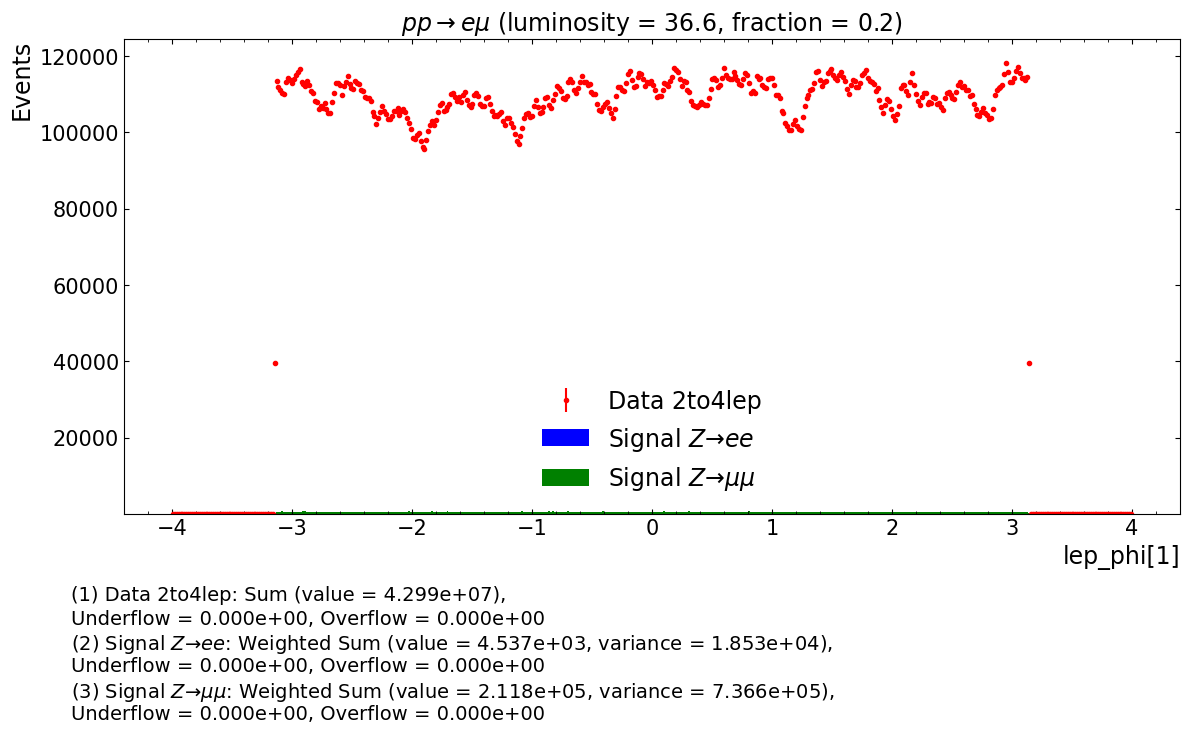

Elapsed time = 5.3s


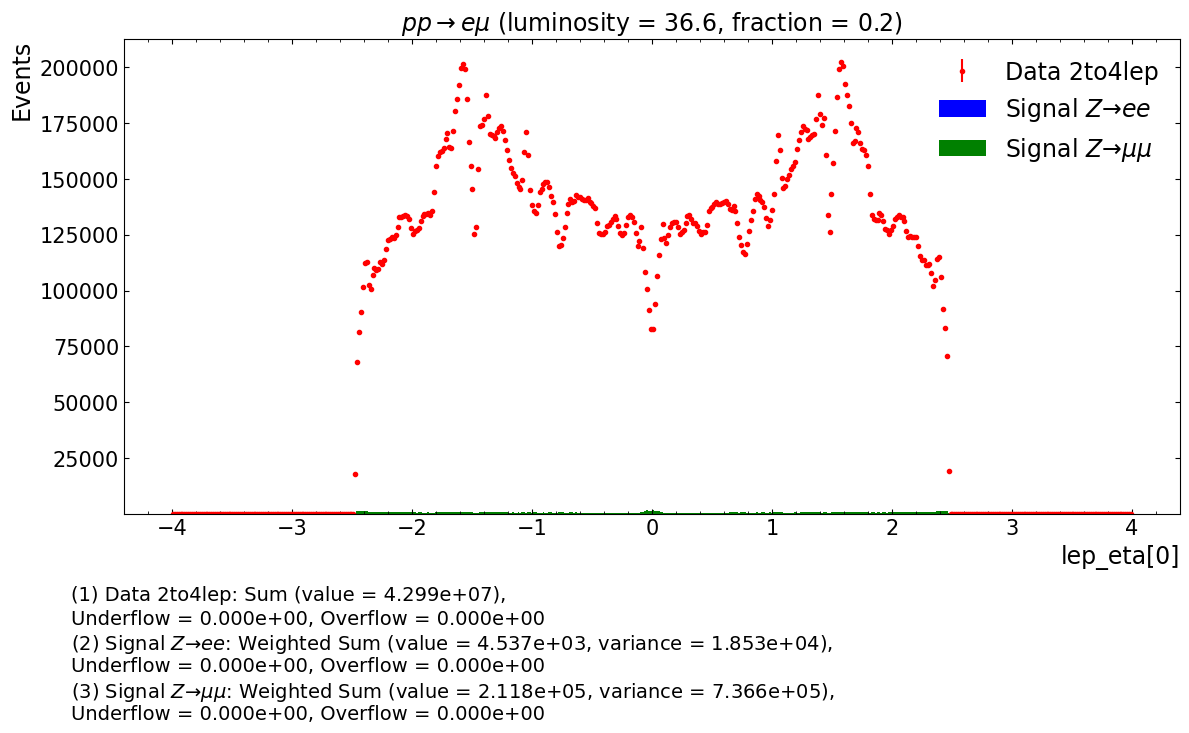

Elapsed time = 7.2s


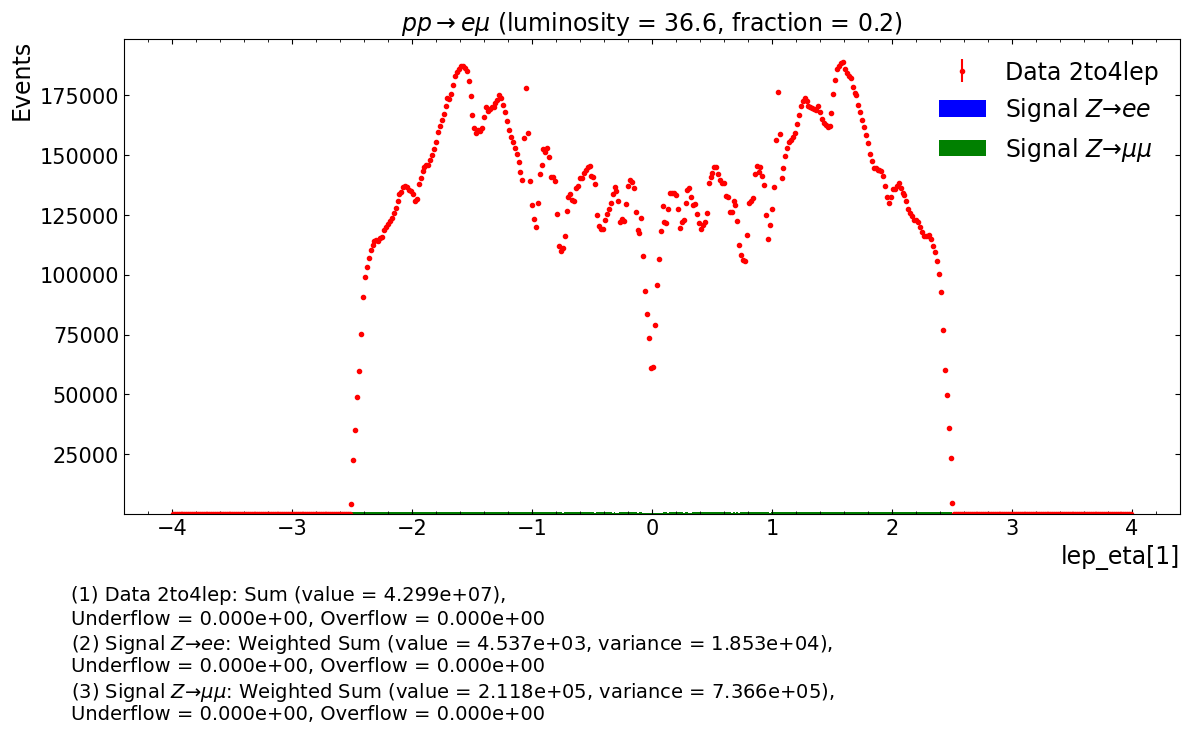

In [5]:
GeV = 1.0
# x-axis range of the plot
xmin = 5 * GeV
xmax = 120 * GeV

num_bins = 500

luminosity, fraction = 36.6, 0.2

selected = dict([list(run1.items())[1], list(run1.items())[2]])


fig_list, hists = plot_histogram_hist(run1,
                   ['lep_phi[0]', 'lep_phi[1]', 'lep_eta[0]', 'lep_eta[1]'],
                   ['r', 'b'
                    , 'g'
                   ],
                   [-4, 4],
                   num_bins,
                   ['lep_phi[0]', 'lep_phi[1]', 'lep_eta[0]', 'lep_eta[1]'], marker='.', show_text=True,
                   title_list=f'$pp\\rightarrow e \\mu$ (luminosity = {luminosity}, fraction = {fraction})')

Elapsed time = 0.9s


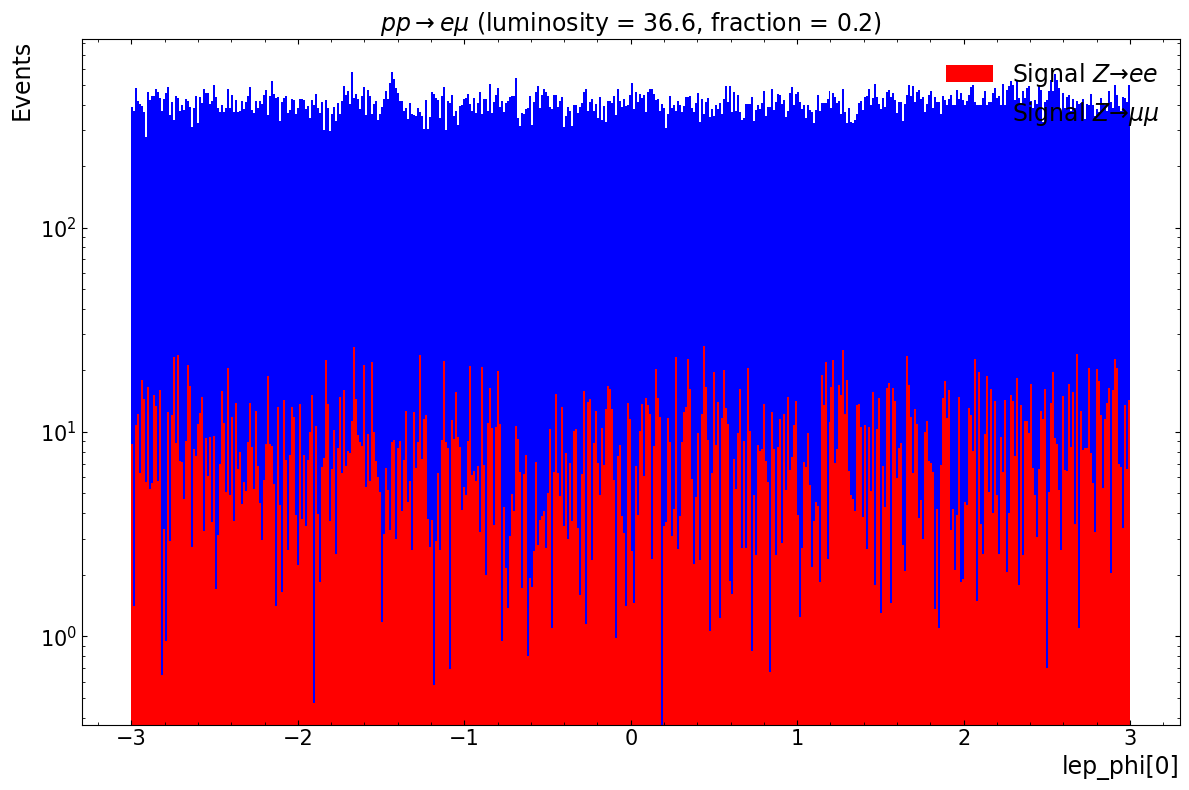

Elapsed time = 2.9s


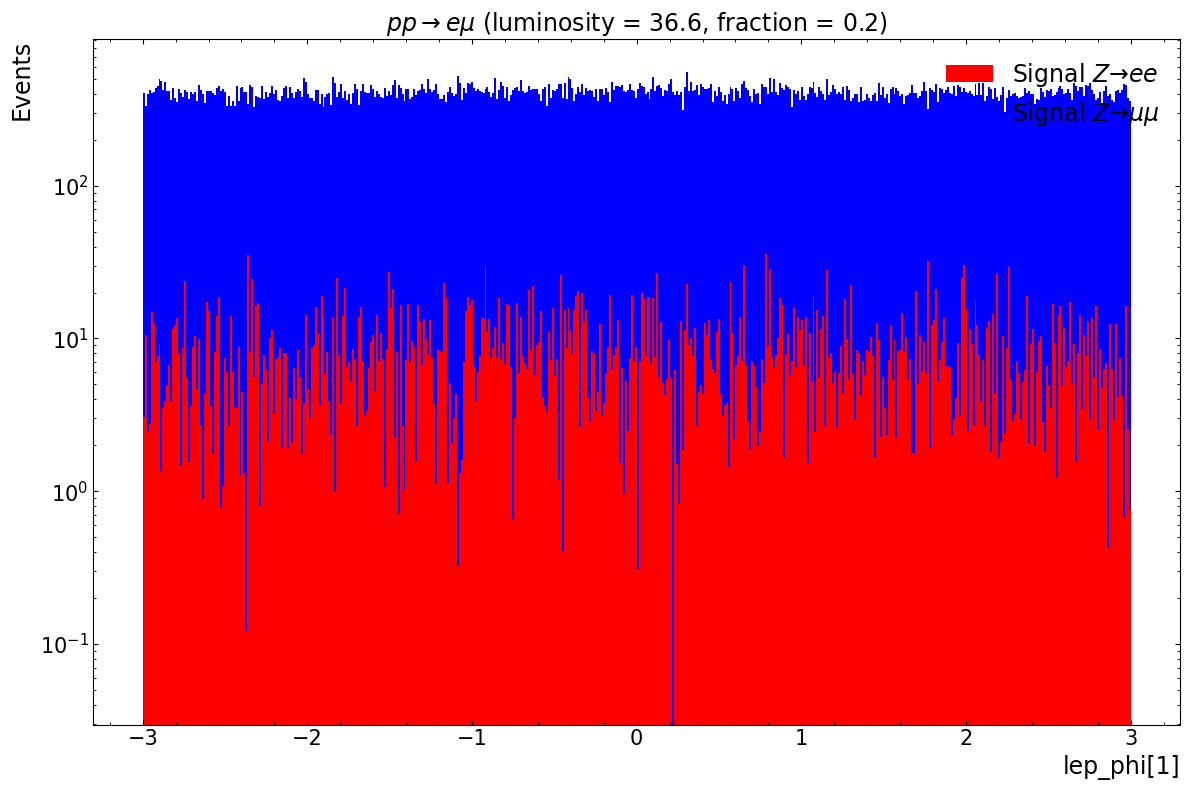

Elapsed time = 5.2s


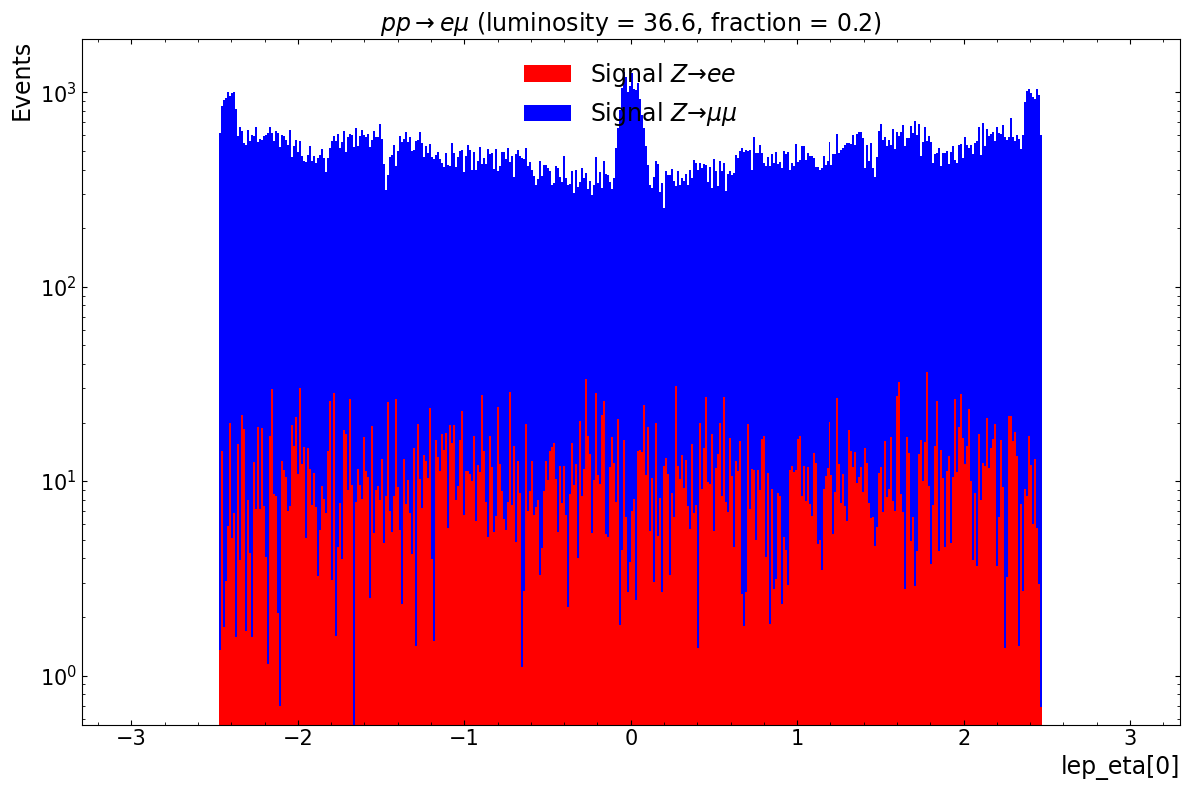

Elapsed time = 7.3s


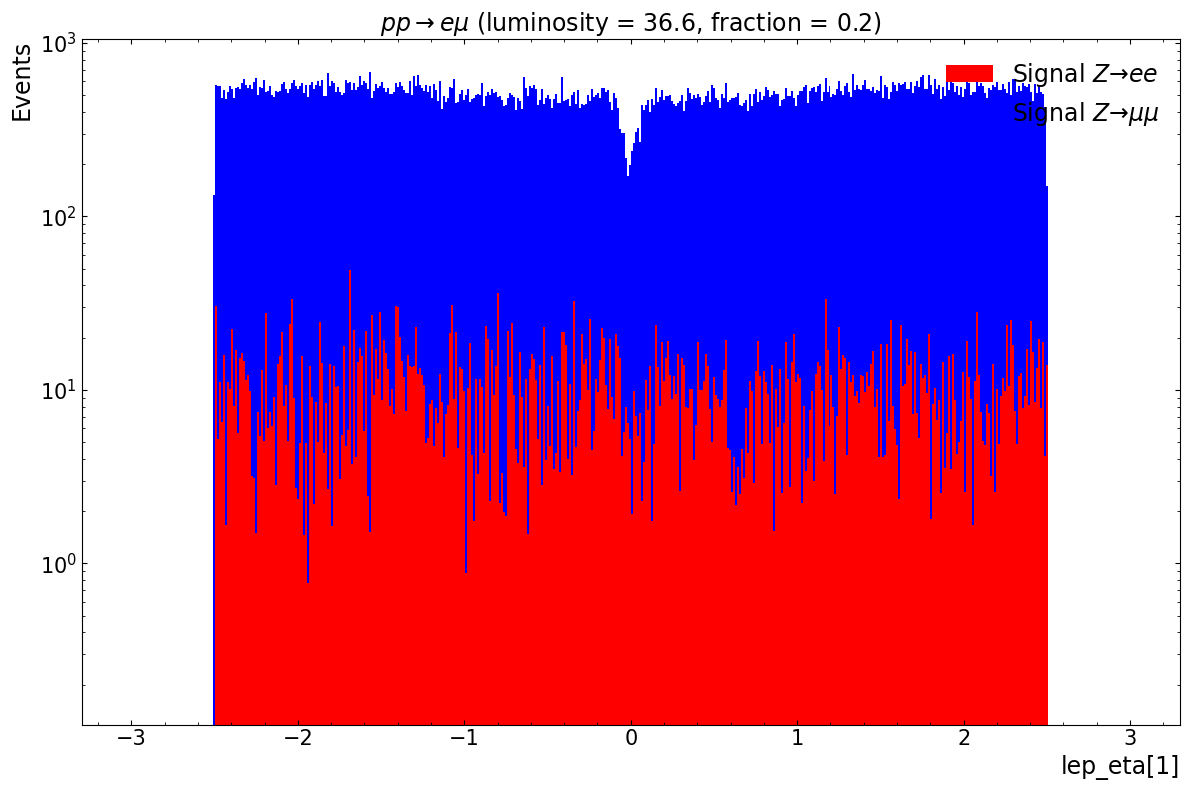

([<Figure size 1200x800 with 1 Axes>,
  <Figure size 1200x800 with 1 Axes>,
  <Figure size 1200x800 with 1 Axes>,
  <Figure size 1200x800 with 1 Axes>],
 [[Hist(Regular(500, -3, 3, name='Signal $Z→ee$'), storage=Weight()) # Sum: WeightedSum(value=4373.73, variance=17959.9) (WeightedSum(value=4537.17, variance=18525.3) with flow),
   Hist(Regular(500, -3, 3, name='Signal $Z→μμ$'), storage=Weight()) # Sum: WeightedSum(value=201669, variance=702241) (WeightedSum(value=211759, variance=736566) with flow)],
  [Hist(Regular(500, -3, 3, name='Signal $Z→ee$'), storage=Weight()) # Sum: WeightedSum(value=4357.71, variance=17870.4) (WeightedSum(value=4537.17, variance=18525.3) with flow),
   Hist(Regular(500, -3, 3, name='Signal $Z→μμ$'), storage=Weight()) # Sum: WeightedSum(value=202524, variance=705353) (WeightedSum(value=211759, variance=736566) with flow)],
  [Hist(Regular(500, -3, 3, name='Signal $Z→ee$'), storage=Weight()) # Sum: WeightedSum(value=4537.17, variance=18525.3),
   Hist(Regular

In [6]:
plot_histogram_hist(selected,
                   ['lep_phi[0]', 'lep_phi[1]', 'lep_eta[0]', 'lep_eta[1]'],
                   ['r', 'b'
                   ],
                   (-3, 3),
                   num_bins,
                   ['lep_phi[0]', 'lep_phi[1]', 'lep_eta[0]', 'lep_eta[1]'], marker='.', logy=True,
                   title_list=f'$pp\\rightarrow e \\mu$ (luminosity = {luminosity}, fraction = {fraction})')

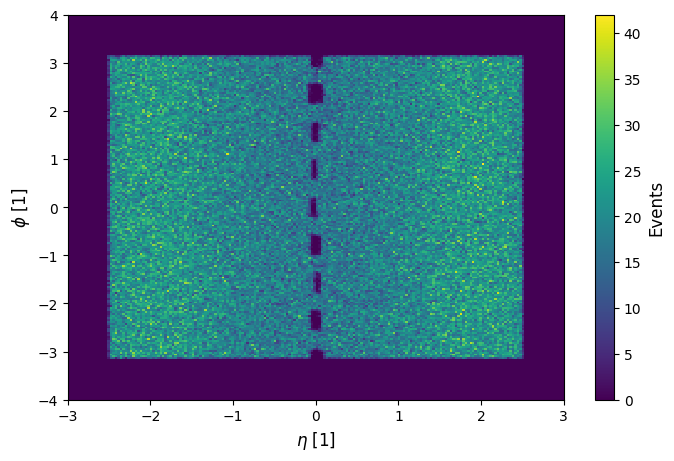

In [11]:
x_data = run1['Signal $Z→μμ$']
y_data = run1['Signal $Z→μμ$']
variable_x = 'lep_eta[1]'
variable_y = 'lep_phi[1]'
x_min_max = (-3, 3)
y_min_max = (-4, 4)
x_num_bins, y_num_bins = 200, 200

fig, hist2d = histogram_2d(data=(x_data, y_data), variable=(variable_x, variable_y), num_bins=(x_num_bins, y_num_bins),
             min_max=(x_min_max, y_min_max), label=('$\\eta$ [1]', '$\\phi$ [1]'), tick_labelsize=10, cbar_label='Events')

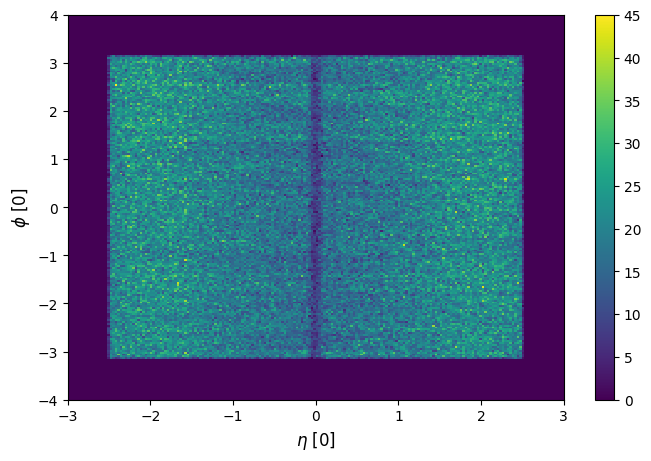

In [12]:
xvariable_x = 'lep_eta[0]'
variable_y = 'lep_phi[0]'

fig, hist2d = histogram_2d(data=(x_data, y_data), variable=(variable_x, variable_y), num_bins=(x_num_bins, y_num_bins),
             min_max=(x_min_max, y_min_max), label=('$\\eta$ [0]', '$\\phi$ [0]'))

## Demonstrate plotting the same variable using different cuts

In [7]:
## Use list of lists
data_list = [run1, run2]
# First list is for run1 (data and MC), the second is for run2 (data and MC)
color_lists = [['r', 'b', 'm'], ['g', 'k', 'c']]
label_list = ['run1', 'run2']
data_list

run = dict([list(run1.items())[1], list(run1.items())[2]])


In [8]:
x = get_results_list(data_list, color_lists, label_list, 'mass')
x

[{'color': 'r',
  'run1 Data 2to4lep mass': <Array [96.5, 31.5, 88, 0.433, ..., 94.9, 9.16, 29.4] type='35958711 * float32'>},
 {'color': 'b',
  'run1 Signal $Z→ee$ mass': <Array [81.6, 92.8, 86.8, 101, ..., 89.6, 91.9, 87.7] type='10089146 * float32'>},
 {'color': 'm',
  'run1 Signal $Z→μμ$ mass': <Array [91.7, 88.5, 92.9, ..., 92.4, 93.6, 89.7] type='10934717 * float32'>},
 {'color': 'g',
  'run2 Data 2to4lep mass': <Array [1.28, 11.5, 0.976, ..., 0.718, 1.06, 0.667] type='433919 * float32'>},
 {'color': 'k',
  'run2 Signal $Z→ee$ mass': <Array [12.3, 32.3, 47.2, 38.1, ..., 37.1, 52.1, 229, 34.9] type='56 * float32'>},
 {'color': 'c',
  'run2 Signal $Z→μμ$ mass': <Array [50.8, 38, 19.7, 75.8, ..., 16.4, 13.9, 0.331] type='5294 * float32'>}]

In [9]:
# def plot_errorbar(main_axes, selected_data, xmin, xmax, num_bins, marker):
#     bin_edges = np.linspace(xmin, xmax, num_bins + 1)
#     bin_centres = (bin_edges[:-1] # left edges
#                     + bin_edges[1:] # right edges
#                       ) / 2
    
#     color = selected_data['color']

#     txt = []
#     for key in selected_data:
#         if 'color' in key or 'totalWeight' in key:
#             continue
                
#         values = ak.to_numpy(selected_data[key])
#         weights = ak.to_numpy(selected_data.get('totalWeight', np.ones_like(values)))

#         h = Hist.new.Reg(num_bins, xmin, xmax, name=key).Weight()
#         h.fill(values, weight=weights)

#         txt.append(f'- {key}: Weighted Sum (value = {h.sum().value:.3e}, '
#                         f'variance = {h.sum().variance:.3e}),')
#         txt.append(f'  Underflow = {h.view()[0].value:.3e}, '
#                         f'Overflow = {h.view()[-1].value:.3e}')
        
#         data = h.view(flow=False).value
#         data_err = np.sqrt(h.view(flow=False).variance)
        
#         # plot the data points
#         main_axes.errorbar(x=bin_centres, y=data, yerr=data_err,
#                             marker=marker, color=color, linestyle='none',
#                             label=f'{key}')
#     return h, txt


# def plot_multiple_runs( data,
#                            xmin,
#                            xmax,
#                            num_bins,
#                            x_label,
#                            y_label='Events',
#                            logy=False,
#                            title='',
#                            marker='o',
#                            title_fontsize=17,
#                            label_fontsize=17,
#                            legend_fontsize=17,
#                            tick_labelsize=15,
#                             text_fontsize=14,
#                             show_text=False,
#                         fig_size=(12, 8)):

#     if xmin >= xmax: 
#         raise ValueError("xmax needs to be larger than xmin.")
        
#     if not isinstance(num_bins, int) or num_bins < 2:
#         raise ValueError("num_bins needs to be an int and greater than 1.")

#     if (
#         not isinstance(fig_size, tuple)
#         or len(fig_size) != 2
#         or not all(isinstance(value, (int, float)) for value in fig_size)
#         or not all(value > 0 for value in fig_size)
#     ):
#         raise ValueError("fig_size must be a tuple of two positive numbers.")
        
#     time_start = time.time()
    
#     fig = plt.figure(figsize=fig_size)  # Create empty figure
        
#     main_axes = plt.gca()

#     text = []
#     hists_list = []
#     for selected_data in data:
#         # {'$p_t$[0] Run 1': {'color': 'b',
#         # 'lep_pt_0': <Array [46.9, 42.8, 35.3, 34.4, ..., 14.2, 51.2, 36.9] type='5276419 * float32'>}} 
#         h, txt = plot_errorbar(main_axes, selected_data, xmin, xmax, num_bins, marker)
#         hists_list.append(h)
#         text.extend(txt)
        
#     if show_text:
#         for i, line in enumerate(text):
#             main_axes.text(-0.05, -0.15 - i * 0.05, line, ha='left', va='top', transform=main_axes.transAxes, fontsize=text_fontsize)
            
    
#     # separation of x axis minor ticks
#     main_axes.xaxis.set_minor_locator(AutoMinorLocator()) 
    
#     # set the axis tick parameters for the main axes
#     main_axes.tick_params(which='both', # ticks on both x and y axes
#                           direction='in', # Put ticks inside and outside the axes
#                           labelsize=tick_labelsize, # Label size
#                           top=True, # draw ticks on the top axis
#                           right=True) # draw ticks on right axis


#     # x-axis label
#     main_axes.set_xlabel(x_label, fontsize=label_fontsize,
#                          x=1, horizontalalignment='right' )
    
#     # write y-axis label for main axes
#     main_axes.set_ylabel(y_label, fontsize=label_fontsize,
#                          y=1, horizontalalignment='right') 
    
#     # draw the legend
#     main_axes.legend(frameon=False, fontsize=legend_fontsize) # no box around the legend    
    
#     main_axes.set_title(title, fontsize=title_fontsize)
    
#     if logy:
#         main_axes.set_yscale('log')

#     elapsed_time = time.time() - time_start 
#     print("Elapsed time = " + str(round(elapsed_time, 1)) + "s") # Print the time elapsed

#     # Show the plot
#     plt.tight_layout()
#     plt.show()
    
#     return fig, hists_list

Elapsed time = 0.9s


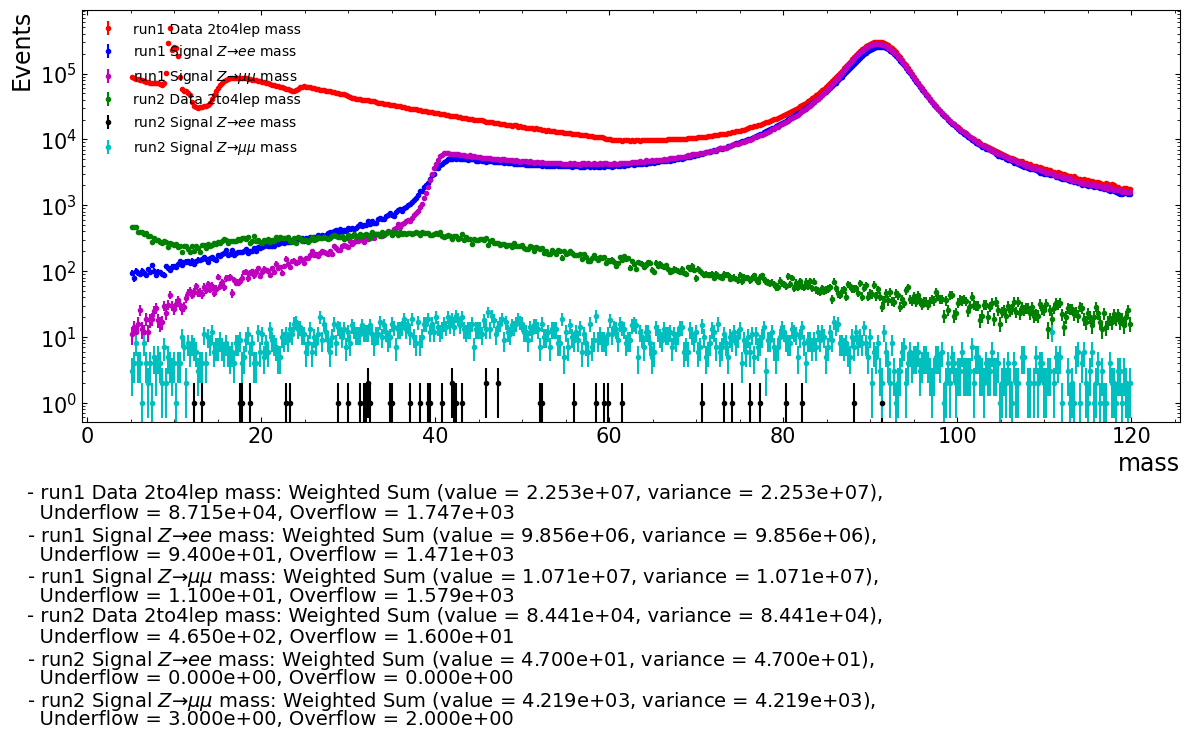

In [14]:
GeV = 1.0
# x-axis range of the plot
xmin = 5 * GeV
xmax = 120 * GeV
# Histogram bin setup
num_bins = 500

fig, hists = plot_multiple_runs(x,
                  xmin,
                  xmax,
                  num_bins,
                  'mass',
                  marker='.', show_text=True, fig_size=(12, 10), logy=True, legend_fontsize=10)

In [15]:
hists

[Hist(Regular(500, 5, 120, name='run1 Data 2to4lep mass'), storage=Weight()) # Sum: WeightedSum(value=2.25345e+07, variance=2.25345e+07) (WeightedSum(value=3.59587e+07, variance=3.59587e+07) with flow),
 Hist(Regular(500, 5, 120, name='run1 Signal $Z→ee$ mass'), storage=Weight()) # Sum: WeightedSum(value=9.85564e+06, variance=9.85564e+06) (WeightedSum(value=1.00891e+07, variance=1.00891e+07) with flow),
 Hist(Regular(500, 5, 120, name='run1 Signal $Z→μμ$ mass'), storage=Weight()) # Sum: WeightedSum(value=1.07126e+07, variance=1.07126e+07) (WeightedSum(value=1.09347e+07, variance=1.09347e+07) with flow),
 Hist(Regular(500, 5, 120, name='run2 Data 2to4lep mass'), storage=Weight()) # Sum: WeightedSum(value=84408, variance=84408) (WeightedSum(value=433919, variance=433919) with flow),
 Hist(Regular(500, 5, 120, name='run2 Signal $Z→ee$ mass'), storage=Weight()) # Sum: WeightedSum(value=47, variance=47) (WeightedSum(value=56, variance=56) with flow),
 Hist(Regular(500, 5, 120, name='run2 Si